In [ ]:
%load_ext autoreload
%autoreload 2
%matplotlib inline
import models

import pandas as pd
import numpy as np
import os
from nltk import word_tokenize
from sklearn.feature_extraction.text import CountVectorizer
from sklearn.model_selection import train_test_split
from sklearn.metrics import confusion_matrix, precision_score, accuracy_score, recall_score, f1_score
from nltk.corpus import stopwords
import re
from keras.callbacks import ModelCheckpoint, TensorBoard
from keras.optimizers import Adam
from keras.layers import Input, Dense, Embedding, Flatten, Dropout
from keras.layers.convolutional import Conv1D
from keras.layers.pooling import MaxPooling1D
from keras.models import Model
from keras.utils import np_utils
from time import time

In [2]:
english_stopwords = set(stopwords.words('english'))
categories = ['Democrat', 'Republican']
tweetsdf = pd.read_csv('democratvsrepublicantweets/ExtractedTweets.csv')
handlesdf = pd.read_csv('democratvsrepublicantweets/TwitterHandles.csv')
raw_tweets = tweetsdf['Tweet']
parties = tweetsdf['Party']
y = 1.0 - np.asarray(parties == 'Democrat')

cv = CountVectorizer(stop_words='english', strip_accents='ascii')
bag_of_words = cv.fit_transform([re.sub(r'https?://[^\s]+', '', tweet) for tweet in raw_tweets])

vocab = {}
for feature, freq in zip(cv.get_feature_names(), bag_of_words.sum(axis=0).tolist()[0]):
    if freq > 10:
        vocab[feature] = freq

vocabulary = list(vocab.keys())
vocabulary_size = len(vocabulary) + 1

word_to_int = {word: i + 1 for i, word in enumerate(vocabulary)}
int_to_word = {i + 1: word for i, word in enumerate(vocabulary)}

encoded_tweets =\
    [[word_to_int.get(word, 0) for word in word_tokenize(re.sub(r'https?://[^\s]+', '', tweet).lower())
      if word in word_to_int]
     for tweet in raw_tweets]

max_tweet_len = max([len(encoded_tweet) for encoded_tweet in encoded_tweets])

X = []
for encoded_tweet in encoded_tweets:
    v = np.zeros(max_tweet_len)
    v[0:len(encoded_tweet)] = encoded_tweet
    X.append(v)
    
X = np.array(X)

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

In [3]:
print('Max tweet length: %s' % max_tweet_len)

Max tweet length: 19


In [4]:
filepath, model = models.model7(vocabulary_size, max_tweet_len)
if filepath in os.listdir():
    model.load_weights(filepath)
model.summary()

Instructions for updating:
Colocations handled automatically by placer.
Instructions for updating:
Please use `rate` instead of `keep_prob`. Rate should be set to `rate = 1 - keep_prob`.
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_1 (InputLayer)         (None, 19)                0         
_________________________________________________________________
embedding_1 (Embedding)      (None, 19, 100)           842500    
_________________________________________________________________
conv1d_1 (Conv1D)            (None, 16, 128)           51328     
_________________________________________________________________
dropout_1 (Dropout)          (None, 16, 128)           0         
_________________________________________________________________
max_pooling1d_1 (MaxPooling1 (None, 8, 128)            0         
_________________________________________________________________
conv1d_2 (Conv1D)    

In [5]:
# models.train(X_train, y_train, model, 'tmp_' + filepath)

In [6]:
predictions = np.argmax(model.predict(X_test), axis=1)

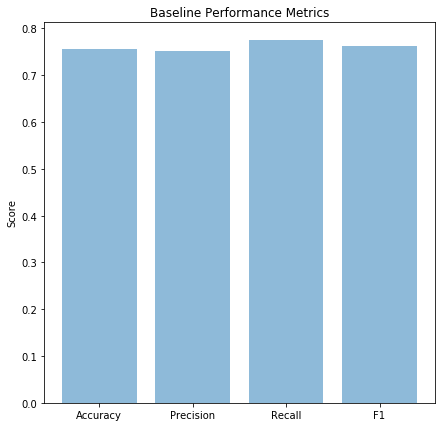

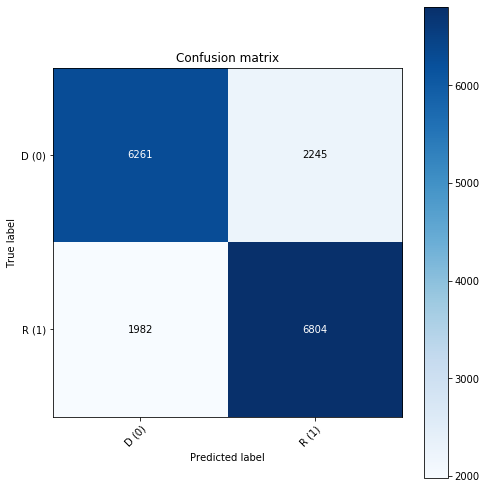

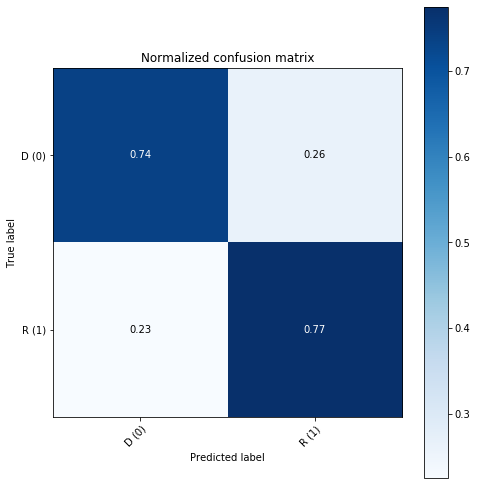

Accuracy: 0.7555517002081887
Precision: 0.7519062879876229
Recall: 0.7744138402003187
F1: 0.7629941126997477


In [8]:
metrics, confusion_matrix = models.plot_results(y_test, predictions)
(accuracy, precision, recall, f1) = metrics
print('Accuracy: %s' % accuracy)
print('Precision: %s' % precision)
print('Recall: %s' % recall)
print('F1: %s' % f1)

In [9]:
metrics

[0.7555517002081887,
 0.7519062879876229,
 0.7744138402003187,
 0.7629941126997477]